In [1]:
from IPython.display import HTML

In [2]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**Aim of notebook**:  
Run ME filters from Kiani's lab on dots stimulus from my dots_db module.

**Theoretical steps:**  
1. import dots_db and Kiani's ME modules
2. extract a trial from the db
3. create ME filters
4. apply filters to stimulus 
5. display ME

In [3]:
import sys
# add location of modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')
# add location of data to path
# sys.path.insert(0,'../../data/')
# sys.path.insert(0,'../modules/dots_db/data/')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
# import pandas as pd
import h5py
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

In [5]:
# plotting options
%matplotlib inline
TITLE_FS = 22
AXES_FS = 22

plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels

<Figure size 432x288 with 0 Axes>

Step 1 completed by now.

In [6]:
file_path = '../modules/dots_db/data/test.h5'
# file_path = '../../data/db1.h5'
database_info = ddb.inspect_db(file_path)
print('INSPECTING DATABASE:')
object_names = []  # list of object names in database
idx = 0
for l1 in database_info.keys():
    object_names.append(l1)
    print(f"\n Object name {idx}: {l1}")  # print initial group names separately because they are extremely long
    pprint.pprint(database_info[l1], width=60)
    idx += 1

INSPECTING DATABASE:

 Object name 0: intlv3_lftTrue_fr60_fs1.1_sp5_ds90_c50_cs10_dleft_nf6_dm5_sc2.5_ppd55.4612_dts6_fw305
{'attrs': [('coh_mean', 50),
           ('coh_stdev', 10),
           ('density', 90),
           ('diameter', 5),
           ('direction', 'left'),
           ('dot_size_in_pxs', 6),
           ('field_scale', 1.1),
           ('frame_rate', 60),
           ('frame_width_in_pxs', 305),
           ('interleaves', 3),
           ('limit_life_time', True),
           ('num_frames', 6),
           ('pixels_per_degree', 55.4612),
           ('speed', 5),
           ('stencil_radius_in_vis_angle', 2.5)],
 'type': 'group'}

 Object name 1: intlv3_lftTrue_fr60_fs1.1_sp5_ds90_c50_cs10_dleft_nf6_dm5_sc2.5_ppd55.4612_dts6_fw305/px
{'attrs': [], 'shape': (100, 558150), 'type': 'dataset'}


In [7]:
# from the previous inspection, we see that the dataset we are interested in has index 1, and its group, 0
dset_idx, gp_idx = 1, 0
gname, dsetname = object_names[gp_idx], object_names[dset_idx]

In [8]:
trial_numbers = [1, 10, 30, 60, 72, 88]  # must be at least 1
dots = [ddb.extract_trial_as_3d_array(file_path, dsetname, gname, trial_number) for trial_number in trial_numbers]

PRINTING TRIAL 88 AS AN EXAMPLE


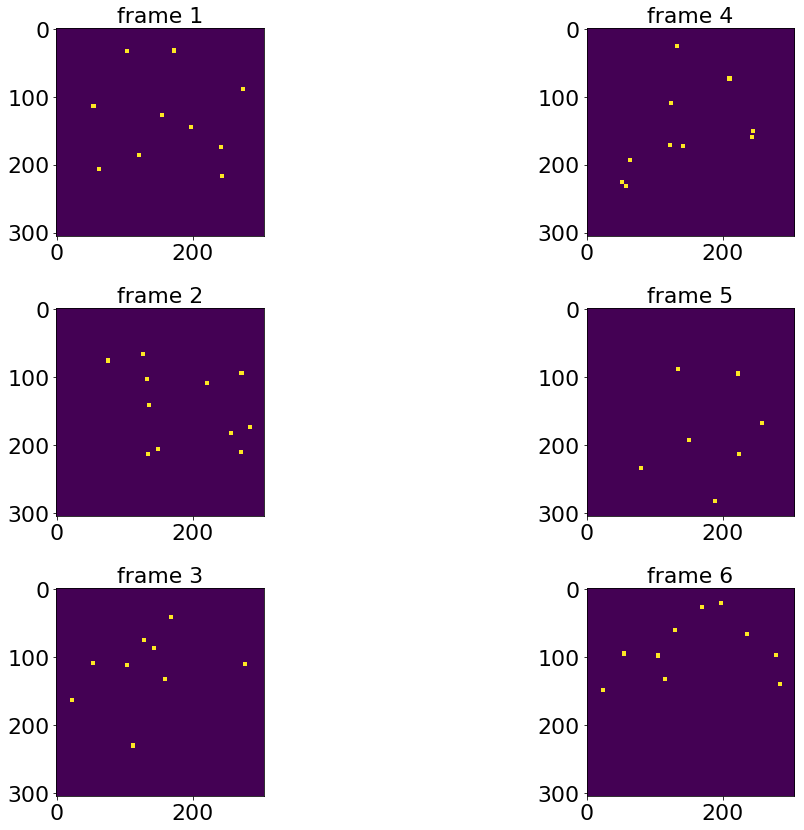

In [9]:
plt.rcParams["figure.figsize"] = (18, 12) # (w, h) # figure size 
fig, axs = plt.subplots(3, 2)

# the following dict conveniently maps frame number to subplot indices,
# in order to display two frames next to each other whenever one is the 'successor' from the other
# i.e., frames 1 and 4 together, then 2 and 5, etc.
frame_to_subplot = {
    0: (0, 0),
    3: (0, 1),
    1: (1, 0),
    4: (1, 1),
    2: (2, 0),
    5: (2, 1)
}
print(f"PRINTING TRIAL {trial_numbers[-1]} AS AN EXAMPLE")
trial = dots[-1]
for frame in range(trial.shape[2]):
    subplot_idx = frame_to_subplot[frame]
    axs[subplot_idx].imshow(trial[:,:,frame])
#     axs[1, 1].set_aspect('equal', 'box')
    axs[subplot_idx].set_title(f"frame {frame + 1}", fontsize=TITLE_FS)

fig.tight_layout()

# plt.show()

Step 2 completed by now

In [10]:
# it is convenient to put the attributes in a dict format
attrs_dict = dict(database_info[gname]['attrs'])
# pprint.pprint(d)

In [11]:
ppd, framerate = attrs_dict['pixels_per_degree'], attrs_dict['frame_rate']
# print(ppd, framerate)
filter_shape = 32, 32, 6                 # size parameter of motion_filters()
filter_res = 1 / ppd, 1 / ppd, 1 / framerate
filters = kiani_me.motion_filters(filter_shape, filter_res)

Step 3 completed

In [12]:
%%time
dots_energy = [kiani_me.apply_motion_energy_filters(x, filters) for x in dots]

CPU times: user 5.67 s, sys: 452 ms, total: 6.12 s
Wall time: 1.54 s


Step 4 completed

<class 'numpy.ndarray'>


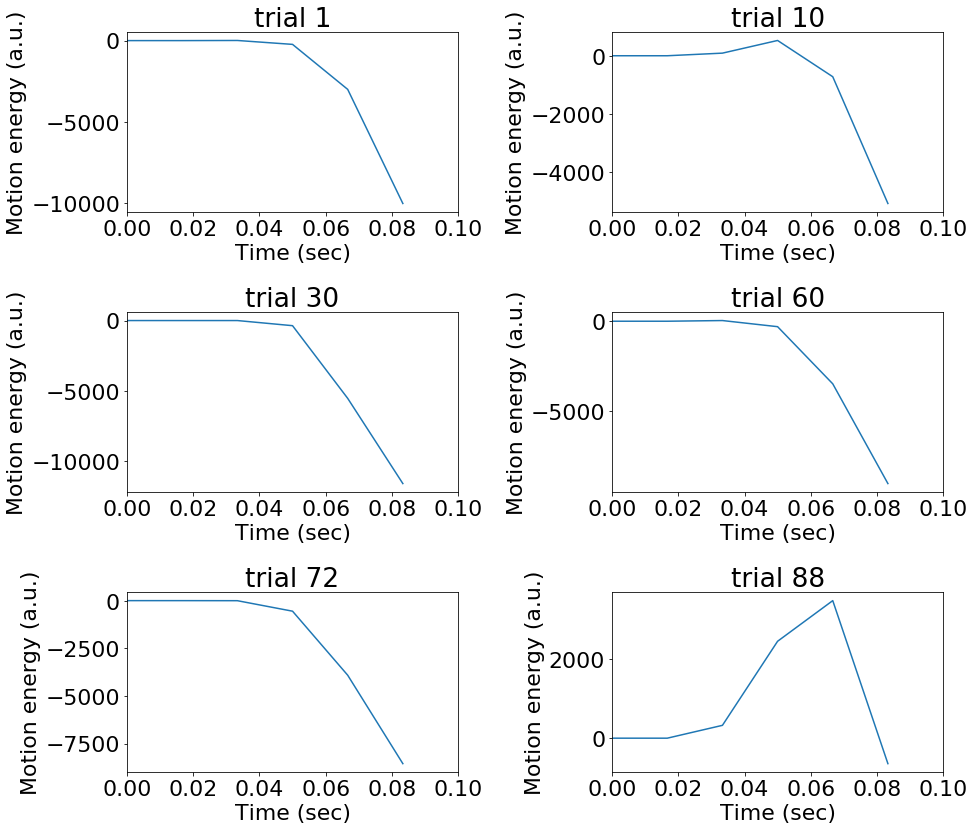

In [13]:
plt.rcParams["figure.figsize"] = (14, 12) # (w, h) # figure size 
subplot_shape = (3, 2)
f, ax = plt.subplots(subplot_shape[0], subplot_shape[1], sharex=False)
print(type(ax))
num_frames = attrs_dict['num_frames']
num_trials = len(trial_numbers)
for trial_number in range(num_trials):
    # next two lines very inefficient/inelegant
#     dots_curr_trial = dots_table[dots_table['trialCount'] == (trial + 2)] # TODO: this hard-coding is NOT ROBUST
#     num_frames = max(dots_curr_trial['frameIdx'])
    
    t = kiani_me.filter_grid(num_frames, 1 / framerate)
    subplot_idx = np.unravel_index(trial_number, subplot_shape)
    if np.sum(subplot_shape):
        ax[subplot_idx].plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
        ax[subplot_idx].set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
                            xlabel="Time (sec)",
                            ylabel="Motion energy (a.u.)", 
                            title=f"trial {trial_numbers[trial_number]}")
    else:       
        ax.plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
        ax.set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
               xlabel="Time (sec)",
               ylabel="Motion energy (a.u.)", 
               title=f"trial {trial_numbers[trial_number]}")
f.tight_layout()

Step 5 complete